In [1]:
from glob import glob
from os.path import exists, join, basename
from tqdm import tqdm
from json import load, dump
from matplotlib import pyplot as plt
from collections import Counter
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from quadtreed3 import Quadtree, Node
from scipy.sparse import csr_matrix
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
from typing import Tuple

import re
import os
import shutil
import random
import cuml
import pickle
import torch
import ndjson

import pandas as pd
import numpy as np

SEED = 20220101

# plt.style.use('ggplot')
# plt.rcParams['figure.dpi'] = 300

/nvmescratch/jay/miniconda3/envs/rapids/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
WORK_DIR = "/nvmescratch/jay/wizmap/temp/"
DATA_DIR = "/nvmescratch/jay/wizmap/data/"

## Download the ACL Meta Data

In [4]:
PARQUET_PATH = join(DATA_DIR, 'acl.parquet')

In [13]:
metadata_df = pd.read_parquet(
    PARQUET_PATH,
    columns=[
        "abstract",
        'year',
        "title",
        "author",
        "acl_id",
    ],
)

# Only get the papers with
metadata_df = metadata_df[metadata_df['abstract'] != '']
metadata_df = metadata_df[metadata_df['title'] != '']
metadata_df = metadata_df[metadata_df['author'] != '']
metadata_df = metadata_df.dropna()
print(metadata_df.shape)
metadata_df.head()

(63213, 5)


,abstract,year,title,author,acl_id
0,There is a need to measure word similarity whe...,2002,A Study on Word Similarity using Context Vecto...,"Chen, Keh-Jiann and\nYou, Jia-Ming",O02-2002
2,Thread disentanglement is the task of separati...,2013,"Headerless, Quoteless, but not Hopeless? Using...","Jamison, Emily and\nGurevych, Iryna",R13-1042
3,"In this paper, we describe a word alignment al...",2005,Aligning Words in {E}nglish-{H}indi Parallel C...,"Aswani, Niraj and\nGaizauskas, Robert",W05-0819
5,The paper 1 presents a rule-based approach to ...,2013,Recognizing semantic relations within {P}olish...,"K{\k{e}}dzia, Pawe{\l} and\nMaziarz, Marek",R13-1044
6,"In this paper we describe LIHLA, a lexical ali...",2005,{LIHLA}: Shared Task System Description,"Caseli, Helena M. and\nNunes, Maria G. V. an...",W05-0818


In [16]:
# for row in tqdm(metadata_df.itertuples()):
#     abstract = row[1].lower()
#     year = row[2]
#     title = row[3].lower()
#     author = row[4].lower()
    
#     if 'diyi' in author:
#         print(title, year)

## Extract Abstract Embedding 

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [89]:
model = SentenceTransformer('all-mpnet-base-v2', device=device)

In [35]:
abstracts = []
for sentence in metadata_df['abstract']:
    abstracts.append(sentence.lower())

In [36]:
embeddings = model.encode(abstracts, batch_size=64, show_progress_bar=True)

Batches: 100%|██████████| 988/988 [11:07<00:00,  1.48it/s]


In [38]:
pickle.dump(embeddings, open(join(DATA_DIR, 'embeddings.pkl'), 'wb'))

In [39]:
# Data: x, y, abstract, title, year

## Create UMAP from Embeddings

In [78]:
n_neighbors = 60
min_dist = 0.1
reducer_cuml = cuml.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric='cosine',
        n_components=2,
        verbose=False,
        random_state=SEED
    )

# Fit UMAP
projected_emb_cuml = reducer_cuml.fit_transform(embeddings)

In [73]:
projected_emb_cuml.shape

(63213, 2)

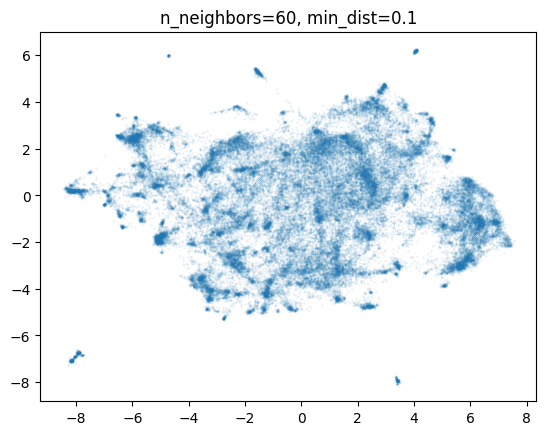

In [79]:
plt.title(f'n_neighbors={n_neighbors}, min_dist={min_dist}')
plt.scatter(projected_emb_cuml[:, 0], projected_emb_cuml[:, 1], s=0.1, alpha=0.2)

In [84]:
# Bundle dataset together
authors = list(map(lambda x: x.lower(), metadata_df['author']))
titles = list(map(lambda x: x.lower(), metadata_df['title']))
years = list(map(lambda x: int(x), metadata_df['year']))

In [85]:
umap_df = pd.DataFrame({
    'xs': projected_emb_cuml[:, 0],
    'ys': projected_emb_cuml[:, 1],
    'abstracts': abstracts,
    'titles': titles,
    'years': years,
    'authors': authors
})

In [86]:
umap_df.to_csv(join(DATA_DIR, 'umap.csv'), index=False)

## Create KDE

In [91]:
cur_df = pd.read_csv(join(DATA_DIR, 'umap.csv'))

In [93]:
xs = cur_df['xs'].to_numpy()
ys = cur_df['ys'].to_numpy()

projected_emb = np.stack((xs, ys), axis=1)

In [95]:
xs = projected_emb[:, 0]
ys = projected_emb[:, 1]

x_min, x_max = np.min(xs), np.max(xs)
y_min, y_max = np.min(ys), np.max(ys)

x_gap = x_max - x_min
y_gap = y_max - y_min

if x_gap > y_gap:
    # Expand the larger range to leave some padding in the plots
    x_min -= x_gap / 50
    x_max += x_gap / 50
    x_gap = x_max - x_min
    
    # Regulate the 2D grid to be a square
    y_min -= (x_gap - y_gap) / 2
    y_max += (x_gap - y_gap) / 2
else:
    # Expand the larger range to leave some padding in the plots
    y_min -= y_gap / 50
    y_max += y_gap / 50
    y_gap = y_max - y_min
    
    # Regulate the 2D grid to be a square
    x_min -= (y_gap - x_gap) / 2
    x_max += (y_gap - x_gap) / 2

# Estimate on a 2D grid
grid_size = 200
grid_xs = np.linspace(x_min, x_max, grid_size)
grid_ys = np.linspace(y_min, y_max, grid_size)
xx, yy = np.meshgrid(grid_xs, grid_ys)

grid = np.vstack([xx.ravel(), yy.ravel()]).transpose()
print(x_min, y_min, x_max, y_max)

-8.79407134 -9.23095064 7.85951834 7.422639039999999


In [98]:
# # Compute the bandwidth using silverman's rule
sample_size = 100000
n = sample_size
d = projected_emb.shape[1]
bw = (n * (d + 2) / 4.)**(-1. / (d + 4))

# We use a random sample to fit the KDE for faster run time
rng = np.random.RandomState(SEED)
random_indexes = rng.choice(range(projected_emb.shape[0]),
                            min(projected_emb.shape[0], sample_size),
                            replace=False)

kde = KernelDensity(kernel='gaussian', bandwidth=bw)
kde.fit(projected_emb[random_indexes, :])

KernelDensity(bandwidth=0.14677992676220697)

In [102]:
# Sklearn
log_density = kde.score_samples(grid)
log_density = np.exp(log_density)
grid_density = np.reshape(log_density, xx.shape)
grid_density.shape

(200, 200)

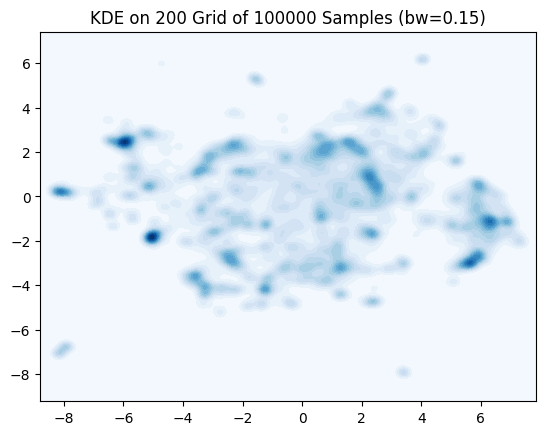

In [105]:
fig = plt.figure()
ax = fig.gca()

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Contourf plot
ax.set_title(f'KDE on {grid_density.shape[0]} Grid of {sample_size} Samples (bw={bw:.2f})')
cfset = ax.contourf(xx, yy, grid_density.round(4),
                    levels=np.linspace(0, np.max(grid_density), 20),
                    cmap='Blues',
                    alpha=1)


## Create KDE for Each Year

(array([8.0000e+00, 3.8000e+01, 6.7000e+01, 1.7100e+02, 7.4500e+02,
        1.9680e+03, 3.5770e+03, 7.2440e+03, 1.5364e+04, 3.4031e+04]),
 array([1952., 1959., 1966., 1973., 1980., 1987., 1994., 2001., 2008.,
        2015., 2022.]),
 <BarContainer object of 10 artists>)

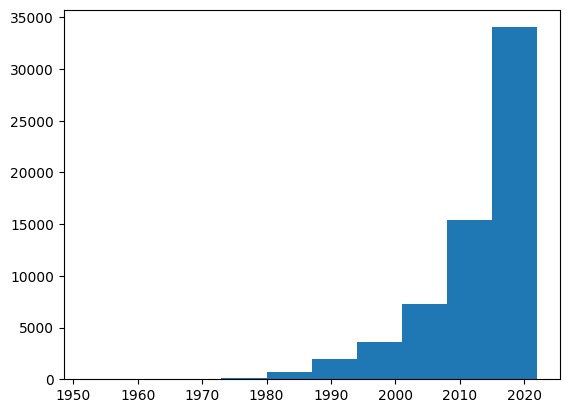

In [109]:
plt.hist(years)

In [125]:
time_grids = {}
for cur_year in tqdm(range(1980, 2022)):
    cur_kde = KernelDensity(kernel='gaussian', bandwidth=bw)

    cur_indexes = np.where(umap_df['years'] == cur_year)[0]
    cur_kde.fit(projected_emb[cur_indexes, :])

    # Compute KDE and transform it to likelihood scale
    cur_log_density = cur_kde.score_samples(grid)
    cur_density = np.exp(cur_log_density)
    cur_grid_density = np.reshape(cur_density, xx.shape)
    cur_grid = cur_grid_density.astype(float).round(4).tolist()

    # Record this year's grid
    time_grids[str(cur_year)] = cur_grid

100%|██████████| 42/42 [00:50<00:00,  1.21s/it]


In [126]:
x_min, x_max, y_min, y_max = float(x_min), float(x_max), float(y_min), float(y_max)

grid_density_json = {
    'grid': grid_density.astype(float).round(4).tolist(),
    'xRange': [x_min, x_max],
    'yRange': [y_min, y_max],
    'sampleSize': sample_size,
    'totalPointSize': umap_df.shape[0],
    'padded': True,
    'timeGrids': time_grids
}

dump(grid_density_json, open(join(DATA_DIR, 'umap-grid.json'), 'w'))

## Pre-compute Embedding Summaries

In [130]:
umap_df = pd.read_csv(join(DATA_DIR, 'umap.csv'))

data = []
texts = []

text_key = 'abstracts'
texts = umap_df[text_key]

xs = umap_df['xs']
ys = umap_df['ys']

# Create data array
for i in range(len(xs)):
    cur_data = {
        'x': xs[i],
        'y': ys[i],
        'pid': i,
    }
    data.append(cur_data)

In [133]:
def top_n_idx_sparse(matrix: csr_matrix, n: int) -> np.ndarray:
    """ Return indices of top n values in each row of a sparse matrix
    Retrieved from:
        https://github.com/MaartenGr/BERTopic/blob/master/bertopic/_bertopic.py#L2801
    Arguments:
        matrix: The sparse matrix from which to get the top n indices per row
        n: The number of highest values to extract from each row
    Returns:
        indices: The top n indices per row
    """
    indices = []
    for le, ri in zip(matrix.indptr[:-1], matrix.indptr[1:]):
        n_row_pick = min(n, ri - le)
        values = matrix.indices[le + np.argpartition(matrix.data[le:ri], -n_row_pick)[-n_row_pick:]]
        values = [values[index] if len(values) >= index + 1 else None for index in range(n)]
        indices.append(values)
    return np.array(indices)


def top_n_values_sparse(matrix: csr_matrix, indices: np.ndarray) -> np.ndarray:
    """ Return the top n values for each row in a sparse matrix
    Arguments:
        matrix: The sparse matrix from which to get the top n indices per row
        indices: The top n indices per row
    Returns:
        top_values: The top n scores per row
    """
    top_values = []
    for row in range(indices.shape[0]):
        scores = np.array([matrix[row, c] if c is not None else 0 for c in indices[row, :]])
        top_values.append(scores)
    return np.array(top_values)

def merge_leaves_before_level(root: Node, target_level: int) -> Tuple[list, list, dict]:
    """
    Merge all nodes to their parents until the tree is target_level tall (modify
    root in-place) and extract all data from leaf nodes before or at the target_level.

    Args:
        root (Node): Root node
        target_level (int): Target level

    Returns:
        csr_row_indexes (list): Row indexes for the sparse matrix. Each row is
            a leaf node.
        csr_column_indexes (list): Column indexes for the sparse matrix. Each column
            is a prompt ID.
        row_node_map (dict): A dictionary map row index to the leaf node.
    """
    
    x0, y0, x1, y1 = root.position
    step_size = (x1 - x0) / (2 ** target_level)

    # Find all leaves at or before the target level
    row_pos_map = {}
    stack = [root]

    # We create a sparse matrix by (data, (row index, column index))
    csr_row_indexes, csr_column_indexes = [], []

    # In the multiplication sparse matrix, each row represents a tile / collection,
    # and each column represents a prompt ID
    cur_r = 0

    while len(stack) > 0:
        cur_node = stack.pop()
        
        if cur_node.level >= target_level:        
            # A new traverse here to concatenate all the prompts from its subtree,
            # and to merge it with its children
            local_stack = [cur_node]
            subtree_data = []

            while len(local_stack) > 0:
                local_node = local_stack.pop()
                
                if len(local_node.children) == 0:
                    # Leaf node
                    subtree_data.extend(local_node.data)
                else:
                    for c in local_node.children[::-1]:
                        if c is not None:
                            local_stack.append(c)
                            
            # Detach all the children and get their data
            cur_node.children = []
            cur_node.data = subtree_data
            
            # Register this node in a dictionary for faster access
            row_pos_map[cur_r] =  list(map(lambda x: round(x, 3), cur_node.position))
            
            # Collect the prompt IDs
            for d in cur_node.data:
                csr_row_indexes.append(cur_r)
                csr_column_indexes.append(d['pid'])
                
            # Move on to the next tile / collection
            cur_r += 1

        else:
            if len(cur_node.children) == 0:
                # Leaf node => it means this leaf is before the target level
                # We need to adjust the node's position so that it has the same
                # size as leaf nodes at the target_level
                x, y = cur_node.data[0]['x'], cur_node.data[0]['y']
                xi, yi = int((x - x0) // step_size), int((y - y0) // step_size)

                # Find the bounding box of current level of this leaf node
                xi0, yi0 = x0 + xi * step_size, y0 + yi * step_size
                xi1, yi1 = xi0 + step_size, yi0 + step_size
                row_pos_map[cur_r] = list(map(lambda x: round(x, 3), [xi0, yi0, xi1, yi1]))
                
                # Collect the prompt IDs
                for d in cur_node.data:
                    csr_row_indexes.append(cur_r)
                    csr_column_indexes.append(d['pid'])
                
                # Move on to the next tile / collection
                cur_r += 1

            else:
                for c in cur_node.children[::-1]:
                    if c is not None:
                        stack.append((c))
    
    return csr_row_indexes, csr_column_indexes, row_pos_map


def get_tile_topics(count_mat, row_pos_map, ngrams, top_k=10):
    """Get the top-k important keywords from all rows in the count_mat.

    Args:
        count_mat (csr_mat): A count matrix
        row_pos_map (dict): A dictionary that maps row index to the corresponding
            leaf node's location in the quadtree
        ngrams (list[str]): Feature names in the count_mat
        top_k (int): Number of keywords to extract
    """
    
    
    # Compute tf-idf score
    t_tf_idf_model = TfidfTransformer()
    t_tf_idf = t_tf_idf_model.fit_transform(count_mat)
    
    # Get words with top scores for each tile
    indices = top_n_idx_sparse(t_tf_idf, top_k)
    scores = top_n_values_sparse(t_tf_idf, indices)

    sorted_indices = np.argsort(scores, 1)
    indices = np.take_along_axis(indices, sorted_indices, axis=1)
    scores = np.take_along_axis(scores, sorted_indices, axis=1)
    
    # Store these keywords
    tile_topics = []

    for r in row_pos_map:
        word_scores = [
            (ngrams[word_index], round(score, 4))
            if word_index is not None and score > 0
            else ("", 0.00001)
            for word_index, score in zip(indices[r][::-1], scores[r][::-1])
        ]

        tile_topics.append({
            'w': word_scores,
            'p': row_pos_map[r]
        })

    return tile_topics

def extract_level_topics(
    root: Node,
    count_mat: csr_matrix,
    texts: list[str],
    ngrams: list[str],
    min_level = None,
    max_level = None
):
    """Extract topics for all leaf nodes at all levels of the quadtree.

    Args:
        root (Noe): Quadtree node
        count_mat (csr_matrix): Count vector for the corpus
        texts (list[str]): A list of all the embeddings' texts
        ngrams (list[str]): n-gram list for the count vectorizer
    """

    level_tile_topics = {}
    
    if min_level is None:
        min_level = 0

    if max_level is None:
        max_level = root.height

    for level in tqdm(list(range(max_level, min_level - 1, -1))):
        # Create a sparse matrix
        csr_row_indexes, csr_column_indexes, row_node_map = merge_leaves_before_level(
            root, level
        )

        csr_data = [1 for _ in range(len(csr_row_indexes))]
        tile_mat = csr_matrix(
            (csr_data, (csr_row_indexes, csr_column_indexes)),
            shape=(len(texts), len(texts)),
        )

        # Transform the count matrix
        new_count_mat = tile_mat @ count_mat

        # Compute t-tf-idf scores and extract keywords
        tile_topics = get_tile_topics(new_count_mat, row_node_map, ngrams)
        
        level_tile_topics[level] = tile_topics
        
    return level_tile_topics


def select_topic_levels(
    max_zoom_scale,
    svg_width,
    svg_height,
    x_domain,
    y_domain,
    tree_extent,
    ideal_tile_width=35,
):
    """
    Automatically determine the min and max topic levels needed for the visualization.

    Args:
        max_zoom_scale (float): Max zoom scale level
        svg_width (int): SVG width
        svg_height (int): SVG height
        x_domain ([float, float]): [x min, x max]
        y_domain ([float, float]): [y min, y max]
        tree_extent ([[float, float], [float, float]]): The extent of the tree
        ideal_tile_width (int, optional): Optimal tile width in pixel. Defaults to 35.
    """

    svg_length = max(svg_width, svg_height)
    world_length = max(x_domain[1] - x_domain[0], y_domain[1] - y_domain[0])
    tree_to_world_scale = (tree_extent[1][0] - tree_extent[0][0]) / world_length

    scale = 1
    selected_levels = []

    while scale <= max_zoom_scale:
        best_level = 1
        best_tile_width_diff = np.Infinity

        for l in range(1, 21):
            tile_num = 2**l
            svg_scaled_length = scale * svg_length * tree_to_world_scale
            tile_width = svg_scaled_length / tile_num

            if abs(tile_width - ideal_tile_width) < best_tile_width_diff:
                best_tile_width_diff = abs(tile_width - ideal_tile_width)
                best_level = l

        selected_levels.append(best_level)
        scale += 0.5

    return np.min(selected_levels), np.max(selected_levels)


In [135]:
# Build the quadtree
tree = Quadtree()
tree.add_all_data(data)

# Build the count matrix
root = tree.get_node_representation()

cv = CountVectorizer(stop_words="english", ngram_range=(1, 1))
count_mat = cv.fit_transform(texts)
ngrams = cv.get_feature_names_out()

63213it [00:00, 66402.43it/s] 


In [137]:
max_zoom_scale = 20
svg_width = 800
svg_height = 800
xs = [d['x'] for d in data]
ys = [d['y'] for d in data]
x_domain = [np.min(xs), np.max(xs)]
y_domain = [np.min(ys), np.max(ys)]

# Get suggestions of quadtree levels to extract
min_level, max_level = select_topic_levels(
    max_zoom_scale, svg_width, svg_height, x_domain, y_domain, tree.extent()
)
print(min_level, max_level)

6 10


In [139]:
level_tile_topics = extract_level_topics(
    root, count_mat, texts, ngrams, min_level=min_level, max_level=max_level
)

100%|██████████| 5/5 [00:20<00:00,  4.03s/it]


In [140]:
data_dict = {
    'extent': tree.extent(),
    'data': {},
    'range': [np.min(xs), np.min(ys), np.max(xs), np.max(ys)]
}

for cur_level in range(min_level, max_level + 1):
    cur_topics = level_tile_topics[cur_level]
    data_dict['data'][cur_level] = []

    for topic in cur_topics:
        # Get the topic name
        name = '-'.join([p[0] for p in topic['w'][:4]])
        x = (topic['p'][0] + topic['p'][2]) / 2
        y = (topic['p'][1] + topic['p'][3]) / 2
        cur_data = {
            'x': round(x, 3),
            'y': round(y, 3),
            'n': name,
            'l': cur_level
        }
        data_dict['data'][cur_level].append(
            [round(x, 3), round(y, 3), name]
        )

In [141]:
dump(data_dict, open(join(DATA_DIR, 'topic-data.json'), 'w'))

## Export NDJSON

In [145]:
umap_df = pd.read_csv(join(DATA_DIR, 'umap.csv'))

text_key = 'abstracts'
time_key = 'years'
label_key = 'titles'

texts = umap_df[text_key]

if time_key is not None:
    times = list(map(str, umap_df[time_key]))
else:
    times = []
    
if label_key is not None:
    labels = umap_df[label_key]
else:
    labels = []

xs = umap_df['xs']
ys = umap_df['ys']

umap_data_short = []

for i in range(len(xs)):
    cur_row = [xs[i], ys[i], texts[i]]
    
    if time_key is not None:
        cur_row.append(times[i])
        
        if label_key is not None:
            cur_row.append(labels[i])
    
    else:
        if label_key is not None:
            cur_row.append('')
            cur_row.append(labels[i])

    umap_data_short.append(cur_row)
    
with open(join(DATA_DIR, "./umap.ndjson"), 'w') as fp:
    ndjson.dump(umap_data_short, fp)